In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import mpld3
import pandas as pd
import imp
import numpy as np
import os
from sqlalchemy import create_engine

sn.set_context('notebook')

# Compare Vannmiljø data export to RESA2

Aquamonitor includes functionality for exporting data in the format required by Vannmiljø. See email from Tron received 24/08/2017 at 14.52 for an overview.

Liv Bente has checked the data in RESA2, but this is not necessarily the same as in Aquamonitor. In addition, I am not yet familiar with the export process in Aquamonitor, so I want to check the output is broadly compatible with the data from RESA already sent to Eva.

In [2]:
# Connect to db
resa2_basic_path = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Upload_Template'
                    r'\useful_resa2_code.py')
resa2_basic = imp.load_source('useful_resa2_code', resa2_basic_path)
engine, conn = resa2_basic.connect_to_resa2()

# Import custom RID functions
rid_func_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
                 r'\Python\rid\notebooks\useful_rid_code.py')
rid = imp.load_source('useful_rid_code', rid_func_path)

## 1. Read Vannmiljø output

The code below reads the output generated by Aquamonitor for submission to Vannmiljø.

In [3]:
# Files exported from AM in Vannmiljø format
# 1. Bielver
bi_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\Results\Chem_Data_To_Vannmiljo\REG_RID_Bielver_2016_or9rppu.csv')
bi_df = pd.read_csv(bi_csv, sep=';', encoding='utf-16-le')

bi_stn_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\Results\Chem_Data_To_Vannmiljo\LOK_RID_Bielver_2016_or9rppu.csv')
bi_stn_df = pd.read_csv(bi_stn_csv, sep=';', encoding='utf-16-le')

# Join
bi_df = pd.merge(bi_df, bi_stn_df, how='left', 
                 left_on='Vannlok_kode', 
                 right_on='VannlokalitetId')

# Get cols of interest
bi_df = bi_df[['Navn', 'Parameter_id', 'Tid_provetak', 
               'Ovre_dyp', 'Nedre_dyp', 'Verdi']]

# 2. Hovedelver
ho_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\Results\Chem_Data_To_Vannmiljo\REG_RID_Hovedelver_2016_ttdrw6q.csv')
ho_df = pd.read_csv(ho_csv, sep=';', encoding='utf-16-le')

ho_stn_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
              r'\Results\Chem_Data_To_Vannmiljo\LOK_RID_Hovedelver_2016_ttdrw6q.csv')
ho_stn_df = pd.read_csv(ho_stn_csv, sep=';', encoding='utf-16-le')

# Join
ho_df = pd.merge(ho_df, ho_stn_df, how='left', 
                 left_on='Vannlok_kode', 
                 right_on='VannlokalitetId')

# Get cols of interest
ho_df = ho_df[['Navn', 'Parameter_id', 'Tid_provetak', 
               'Ovre_dyp', 'Nedre_dyp', 'Verdi']]

# Stack
df = pd.concat([ho_df, bi_df], axis=0)

# Average duplicates
df = df.groupby(['Navn', 'Parameter_id', 'Tid_provetak', 
                 'Ovre_dyp', 'Nedre_dyp']).sum().reset_index()

# Pivot
df.set_index(['Navn', 'Tid_provetak', 'Ovre_dyp', 
              'Nedre_dyp', 'Parameter_id'], inplace=True)
df = df.unstack(level=-1)
df.reset_index(inplace=True)
df.columns = (list(df.columns.get_level_values(0)[:4]) + 
              list(df.columns.get_level_values(1)[4:]))

# Get just surface data for comparison
df = df.query('(Ovre_dyp==0) and (Nedre_dyp==0)')

# Parse date times
df['Tid_provetak'] = pd.to_datetime(df['Tid_provetak'])

df.head()

,Navn,Tid_provetak,Ovre_dyp,Nedre_dyp,AG,AS,CD,CR,CU,HG,...,NI,P-PO4,P-TOT,PB,PH,STS,TEMP,TOC,TURB,ZN
107,Alna,2016-01-05 11:00:00,0.0,0.0,0.0170,0.38,0.040,0.43,2.68,0.001,...,0.99,54.0,57.0,0.532,7.96,8.88,NaN,4.2,6.6,10.2
828,Alna,2016-02-04 11:00:00,0.0,0.0,0.0083,0.31,0.036,0.38,2.65,0.003,...,0.88,47.0,62.0,0.485,7.89,7.64,NaN,4.1,5.8,10.2
1462,Alna,2016-03-02 11:00:00,0.0,0.0,0.0120,0.35,0.036,0.53,3.51,0.011,...,0.94,220.0,250.0,0.362,7.90,13.90,2.1,5.4,10.0,11.9
2301,Alna,2016-04-06 10:00:00,0.0,0.0,0.0140,0.39,0.041,0.69,3.34,0.001,...,1.11,36.0,54.0,0.846,7.69,15.90,NaN,5.2,10.0,12.0
3094,Alna,2016-05-09 10:00:00,0.0,0.0,0.0140,0.33,0.033,0.43,2.68,0.001,...,0.97,22.0,34.0,0.321,8.14,3.00,NaN,4.2,2.5,7.1


## 2. Read RESA data

This code reads the raw concentration data already sent to Eva at NIBIO.

In [4]:
# RESA2 data
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Results\Loads_CSVs\rid_conc_and_loads_summaries_2016.xlsx')
re_df = pd.read_excel(in_xlsx, sheetname='concs_rid_11-36_2016')

# Tidy
del re_df['station_id'], re_df['station_code'], re_df['rid_group']
del re_df['ospar_region'], re_df['Qs_m3/s']

for col in re_df.columns:
    if col.split('_')[1]=='flag':
        del re_df[col]
        
# Convert dates to hourly
re_df['sample_date'] = re_df['sample_date'].values.astype('<M8[h]')

re_df.head()

,station_name,sample_date,Ag_µg/l,As_µg/l,Cd_µg/l,Cr_µg/l,Cu_µg/l,Hg_ng/l,KOND_mS/m,NH4-N_µg/l N,...,PO4-P_µg/l P,Pb_µg/l,SPM_mg/l,SiO2_mg SiO2/l,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P,TURB860_FNU,Zn_µg/l,pH_None
0,Numedalslågen,2016-01-04 10:00:00,0.0087,0.18,0.0200,0.210,0.68,1,3.93,31,...,6,0.253,3.37,4.885714,4.1,540.0,11,4.2,4.4,6.96
1,Numedalslågen,2016-02-01 13:00:00,0.0025,0.14,0.0120,0.160,0.61,1,4.15,32,...,6,0.189,2.82,4.478571,3.2,545.0,9,4.8,3.1,6.93
2,Numedalslågen,2016-03-01 09:00:00,0.0024,0.12,0.0099,0.097,0.42,12,2.92,41,...,3,0.131,2.48,3.235714,2.2,325.0,6,1.5,2.1,6.90
3,Numedalslågen,2016-04-04 09:00:00,0.0022,0.16,0.0190,0.220,0.72,1,3.14,16,...,5,0.244,3.88,4.200000,5.2,420.0,9,2.9,3.9,6.77
4,Numedalslågen,2016-05-04 08:00:00,0.0020,0.16,0.0110,0.140,0.65,1,3.48,28,...,4,0.202,3.50,4.071429,4.0,445.0,7,2.7,3.1,6.93


## 3. Join and compare

In [5]:
# Join
df = pd.merge(df, re_df, how='left',
              left_on=['Navn', 'Tid_provetak'],
              right_on=['station_name', 'sample_date'])

# Tidy
df.drop(['Navn', 'Tid_provetak', 'Ovre_dyp', 'Nedre_dyp',
         'station_name', 'sample_date'], axis=1,
        inplace=True) 

# Manually adjust column names so values can be directly compared
df.columns = [i.upper() for i in df.columns]
df[u'N-NH4_MG/L'] = df[u'NH4-N_ΜG/L N']
del df[u'NH4-N_ΜG/L N']

df[u'N-NO3_MG/L'] = df[u'NO3-N_ΜG/L N']
del df[u'NO3-N_ΜG/L N']

df[u'N-TOT_MG/L'] = df[u'TOTN_ΜG/L N']
del df[u'TOTN_ΜG/L N']

df[u'P-TOT_MG/L'] = df[u'TOTP_ΜG/L P']
del df[u'TOTP_ΜG/L P']

df[u'P-PO4_MG/L'] = df[u'PO4-P_ΜG/L P']
del df[u'PO4-P_ΜG/L P']

df[u'STS_MG/L'] = df[u'SPM_MG/L']
del df[u'SPM_MG/L']

df[u'TURB_FNU'] = df[u'TURB860_FNU']
del df[u'TURB860_FNU']

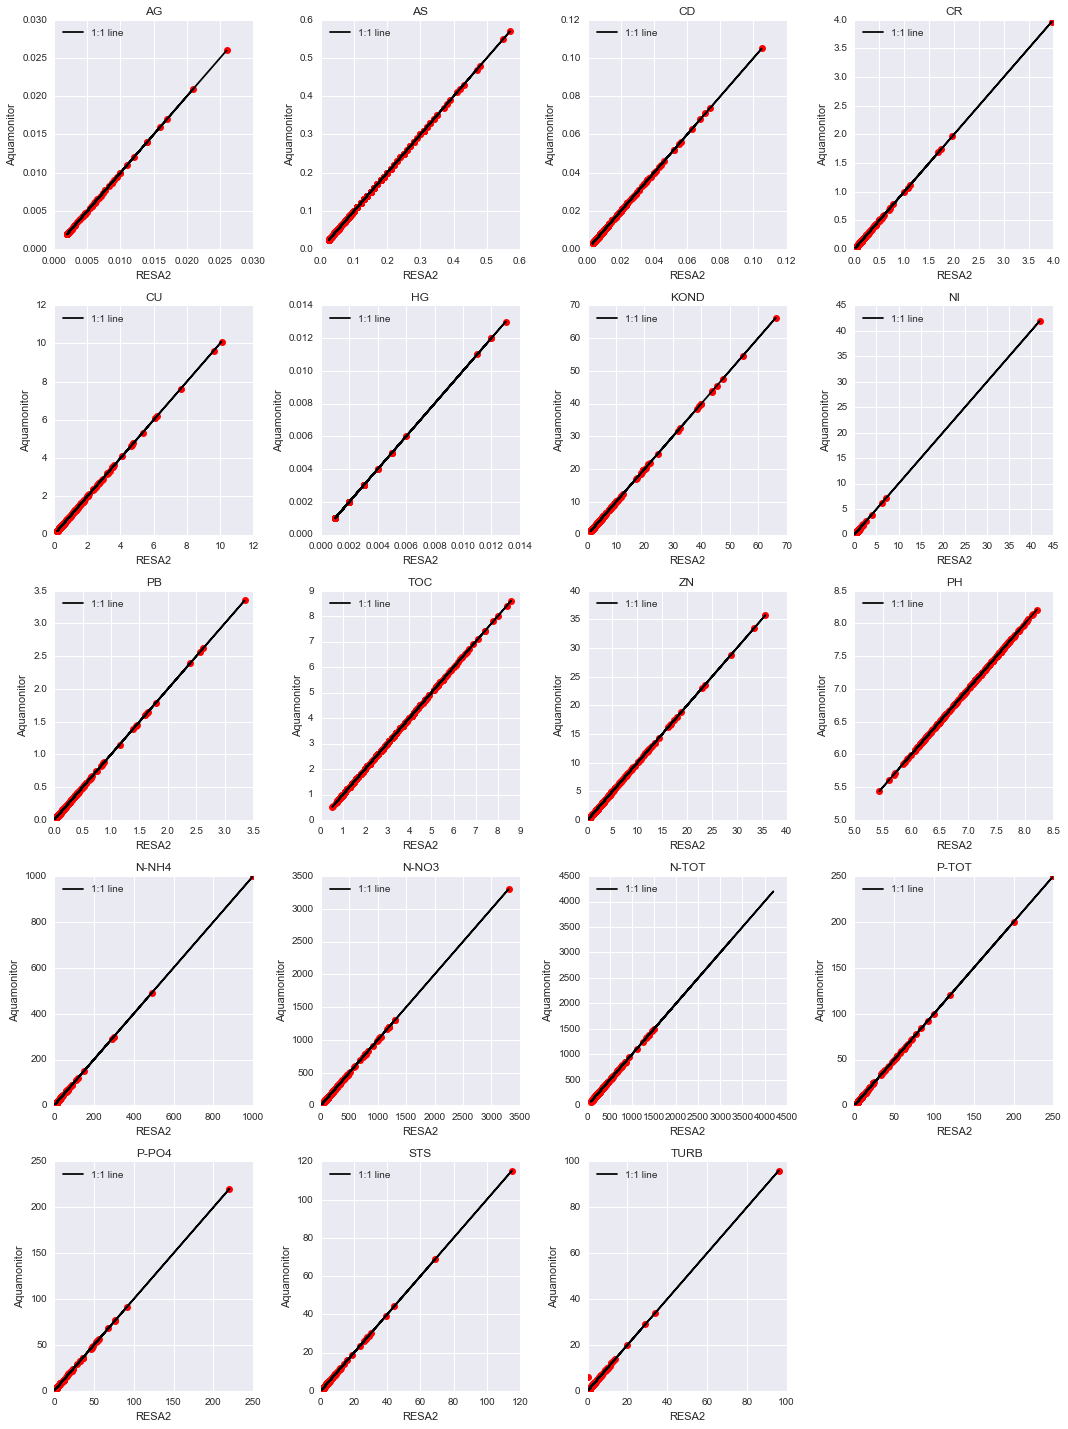

In [6]:
# Pars to plot
pars = [u'AG_ΜG/L', u'AS_ΜG/L', u'CD_ΜG/L',
        u'CR_ΜG/L', u'CU_ΜG/L', u'HG_NG/L', 
        u'KOND_MS/M', u'NI_ΜG/L', u'PB_ΜG/L', 
        u'TOC_MG C/L', u'ZN_ΜG/L', u'PH_NONE', 
        u'N-NH4_MG/L', u'N-NO3_MG/L', 
        u'N-TOT_MG/L', u'P-TOT_MG/L',
        u'P-PO4_MG/L', u'STS_MG/L', u'TURB_FNU']

# Plot
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15,20))
axes = axes.flatten()
fig.delaxes(axes[-1])

# Loop over pars
for idx, par in enumerate(pars):
    # Convert RESA ng/l to Vannmiljø ug/l for Hg
    if par==u'HG_NG/L':
        df[par] = df[par]/1000
        
    # Plot dataset
    axes[idx].plot(df[par], df[par.split('_')[0]], 'ro', label='')
    axes[idx].plot(df[par], df[par], 'k-', label='1:1 line')
    axes[idx].set_xlabel('RESA2')
    axes[idx].set_ylabel('Aquamonitor')
    axes[idx].set_title(par.split('_')[0])
    axes[idx].legend(loc='upper left')
    
plt.tight_layout()
plt.show()